# ResNet Presentation
In this presentation we will be looking at the paper https://arxiv.org/pdf/1602.07261.pdf

## Why ResNets?
- The main driving factor is the belief that deeper networks are better than shallow ones (this is somewhat theoretically justified in some work, for example in "Deep vs. Shallow Networks: an Approximation Theory Perspective" by Mhaskar and Poggio
- Experimentally, the previous winners of ImageNet had been improving by increasing network depth from 8 convolutional layers to around 20 layers. Was there a way to take this much further?

<img src="https://i.imgur.com/StN3FtE.jpg", width=600>

<img src="https://adeshpande3.github.io/assets/GoogLeNet5.png",width=600>

## We can try but...

A problem arises when we try this in the manner of previous designs. Introducing more layers causes a 'degredation' problem, in where both the training and the test error increases when more layers were added. This is perhaps counterintuitive, as the added layers could be simply the identity mapping, and then we would expect performance as good as the shallower network.

<img src="https://i.imgur.com/p7Ezh0o.png",width=600>

## ResNets - a simple idea to avoid degredation
This leads to the idea to add shortcuts, or residual connections. 

Imagine that the ideal mapping for a 2 layer network was $H(x)$, a standard ConvNet has to learn this mapping directly, a ResNet can now instead learn $H(x)-x$. While theoretically ConvNets should be able to handle both, practially, this may be a simpler function to learn.

<img src="https://i.imgur.com/WxJZeH5.png">

## The Restrictions
The most obvious restriction imposed by this is that the number of pixels in an activation $x$ must be the same as in $F(x)$. The previous state of the art, VGGNet, has nearly this design.

<img src="https://i.imgur.com/D8zcLta.jpg">

Groups of layers have the same size, but after 3 or 4 layers, the spatial size is reduced (adding location invariance), and the number of channels are increased (going from more repeatable simple shapes in early layers to less repeatable complex shapes in later layers).


## Projection Layers

ResNets experimented with a few different ways to handle the resolution changes introduced by downsampling but increasing channel size. They experimentally found that simply having a normal convolutional layer (with a stride higher than 1) was a good way to handle this. I.e. there is no residual passing through this layer. 

Note that this is done anyway for the first layer, to project the RGB input to 64 channels.

## BottleNeck Layers and 1x1 Convolutions
This is not so important, but is mentioned in the paper so it is worth looking at.

The idea of $1\times 1$ convolutions was used heavily in the inception model (the previous year's best model, alongside VGG). Having a $1\times 1$ convolution is effectively the same as summing the channels of the activation with different gains. No spatial shift can be applied, but you can now have multiple different combinations of the previous layer's channels, and this is computationally very useful. Now we can reduce the channel dimension before doing larger spatial convolutions and then increase it again with more $1\times 1$ convolutions.

Microsoft do just that in their 'deeper' models with the BottleNeck layers.

<img src="https://i.imgur.com/dzT3A0M.png">

<img src="https://i.imgur.com/BIwgy52.png">

### BottleNeck Convolutions analysis
Comparison of number of operations:

Assume input has spatial dimensions $N \times N$. The standard convolutional layer will have $C$ channels, and the bottleneck architecture will have $4C$.

**Learned parameters**
Standard convolution has $3\times 3 \times C \times C + 3\times 3 \times C \times C = 18C^2$ learned parameters

Bottleneck convolution has $1 \times 1 \times 4C \times C + 3\times 3 \times C \times C + 1\times 1\times C\times 4C = 17C^2$ learnable parameters

**Computational Cost**
Standard convolutional layer has spatial size $N \times N$ pixels. Each spatial location for 1 filter uses $9C$ multiply-adds (madds), giving $9CN^2$ madds per filter, or $9C^2N^2$ madds for the first layer, and the same for the second.

Bottleneck convolutional layer has the same spatial size. 
- The first filter uses $4C$ madds per spatial location, giving $4CN^2$ madds per filter, or $4C^2N^2$ madds in total (C filters). 
- The second layer uses $9C$ madds per spatial location, giving $9CN^2$ madds per filter, or $9C^2N^2$ madds in total (C filters).
- The third layer uses $C$ madds per spatial location, giving $CN^2$ madds per filter, or $4C^2N^2$ madds in total (4C filters)

This means the bottleneck convolution has similar parameter and computational cost ($17C^2$ vs $18C^2$ parameters and multiply-adds per spatial location), but now we've had 3 'layers' of convolution rather than 2.

# The Results
<img src="https://i.imgur.com/w9o1T5q.png">

## Variance Analysis

Firstly, Notice that resnet weights have less energy - learning the residual does break the task down.

Secondly, the std doesn't go to 0 as the layer index increases, meaning that it is learning more than just the residual.

<img src="https://i.imgur.com/aIcM2K1.png">

# Some Code

In [9]:
import os

# Packages for loading images
from PIL import Image

# Numerical packages
import tensorflow as tf
import numpy as np
import plotters
import tf_ops

os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Plotting packages
%matplotlib notebook
import matplotlib.pyplot as plt
W = 7

## First, we look at a 'plain' network - i.e. no feedforward summing

In [10]:
from PIL import Image
import requests
from io import BytesIO


# Can use any image url, or a local image if you prefer
example_img = 'http://i.imgur.com/drZUCM5.jpg'
response = requests.get(example_img)
img_pil = Image.open(BytesIO(response.content))
img = np.array(img_pil).astype(np.float32)

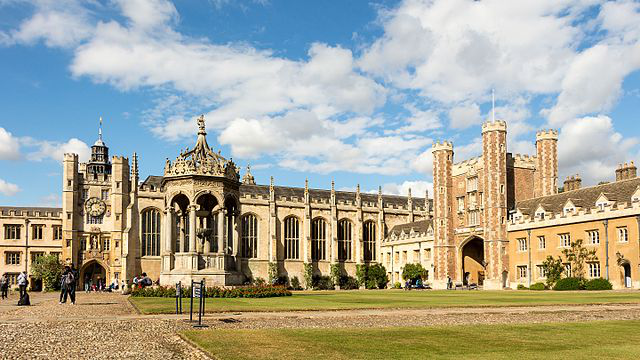

In [3]:
img_pil

In [4]:
def residual_core(x, out_dim, stride):
    """Define the core mapping of a res layer, i.e. F(x)
    """
    strides=(stride, stride)
    x = tf.nn.relu(x)
    x = tf.layers.conv2d(x, out_dim, kernel_size=3, strides=strides, padding='same', name='sub1')
    x = tf.nn.relu(x)
    x = tf.layers.conv2d(x, out_dim, kernel_size=3, strides=(1,1), padding='same', name='sub2')
    
    return x

In [38]:
tf.reset_default_graph()
tf.set_random_seed(5)
x_in = tf.placeholder(tf.float32, [None, *img.shape])

# Forward pass
with tf.variable_scope('layer1'):
    l1 = residual_core(x_in, 3, 1)

with tf.variable_scope('layer2'):
    l2 = residual_core(l1, 3, 1)

with tf.variable_scope('layer3'):
    l3 = residual_core(l2, 3, 1)
    

In [39]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l1_n, l2_n, l3_n = sess.run([l1, l2, l3], {x_in : [img]})

<IPython.core.display.Javascript object>


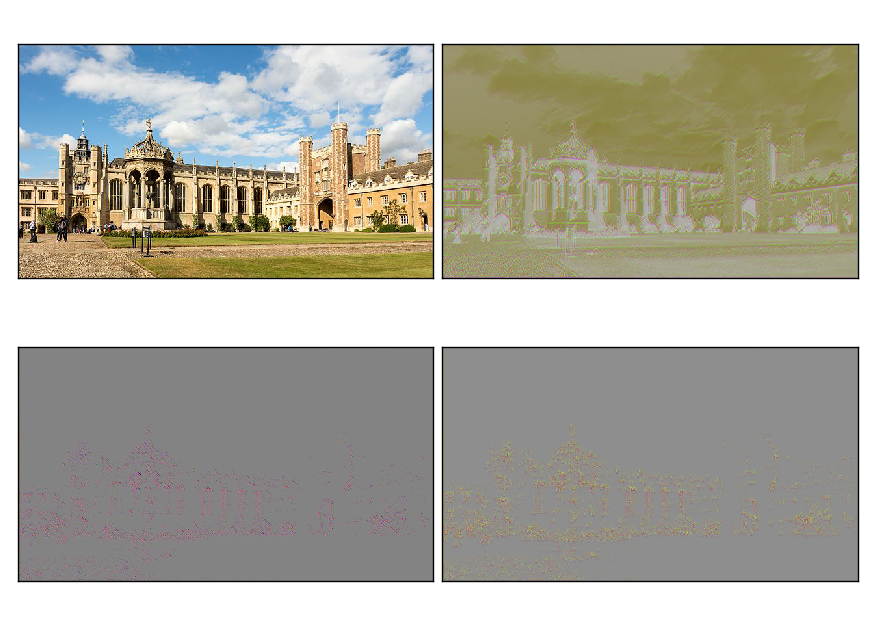

In [40]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(7,5))
ax[0,0].imshow(plotters.normalize(img))
ax[0,1].imshow(plotters.normalize(l1_n[0]))
ax[1,0].imshow(plotters.normalize(l2_n[0]))
ax[1,1].imshow(plotters.normalize(l3_n[0]))

## Residual Nets

In [42]:
def residual(x, out_dim, stride):
    """Define the full residual layer, i.e. x + F(x)
    """
    
    # The projection mapping
    if stride != 1:
        strides=(stride, stride)
        x = tf.layers.conv2d(x, out_dim, kernel_size=3, strides=strides, padding='same')
        
    orig_x = x
    x = residual_core(x, out_dim, 1)
    x += orig_x
    return x

In [46]:
tf.reset_default_graph()
tf.set_random_seed(5)
x_in = tf.placeholder(tf.float32, [None, *img.shape])
# Forward pass
with tf.variable_scope('layer1'):
    l1 = residual(x_in, 3, 1)

with tf.variable_scope('layer2'):
    l2 = residual(l1, 3, 1)

with tf.variable_scope('layer3'):
    l3 = residual(l2, 3, 1)
    

In [47]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l1_n, l2_n, l3_n = sess.run([l1, l2, l3], {x_in : [img]})

<IPython.core.display.Javascript object>


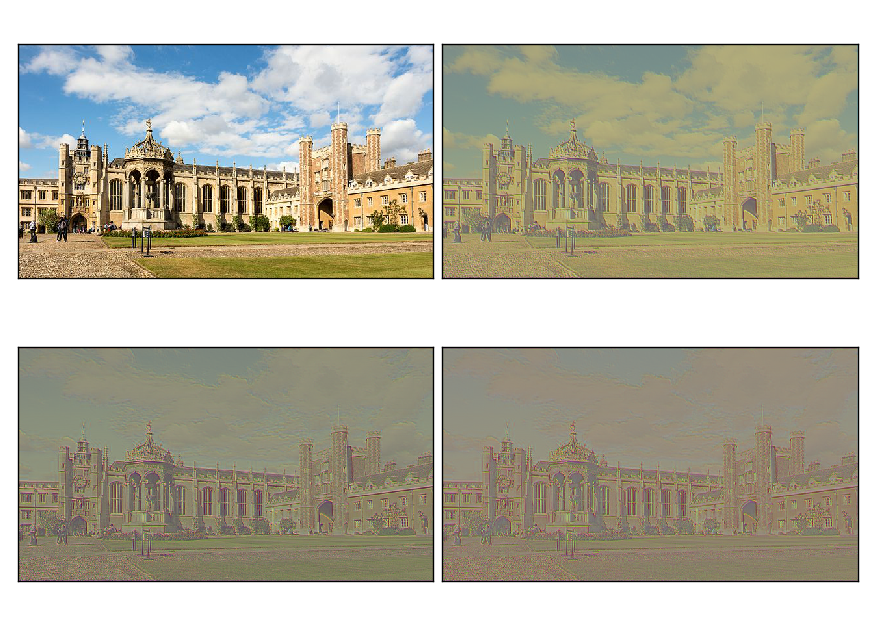

In [48]:
fig, ax = plotters.plot_axgrid(2, 2, figsize=(7,5))
ax[0,0].imshow(plotters.normalize(img))
ax[0,1].imshow(plotters.normalize(l1_n[0]))
ax[1,0].imshow(plotters.normalize(l2_n[0]))
ax[1,1].imshow(plotters.normalize(l3_n[0]))